<a href="https://colab.research.google.com/github/AntoninaRemizova/ML/blob/main/ML_class_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q https://github.com/AntoninaRemizova/ML/archive/refs/heads/main.zip

In [2]:
!nvidia-smi

Mon Dec 15 23:03:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install tensorflow

# импорт

In [4]:
import pandas as pd
import seaborn as sns
import os
import shutil
import random
from glob import glob
import zipfile
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


np.random.seed(42)

In [5]:
os.makedirs('/content/data/tiger', exist_ok=True)
os.makedirs('/content/data/zebra', exist_ok=True)

In [6]:
with zipfile.ZipFile('main.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ml_data')
import shutil

tiger_files = glob('/content/ml_data/ML-main/tiger/*.jpg') + glob('/content/ml_data/ML-main/tiger/*.jpeg') + glob('/content/ml_data/ML-main/tiger/*.png')
for i, file_path in enumerate(tiger_files[:100]):
    shutil.copy(file_path, f'/content/data/tiger/tiger_{i:03d}.jpg')

zebra_files = glob('/content/ml_data/ML-main/zebra/*.jpg') + glob('/content/ml_data/ML-main/zebra/*.jpeg') + glob('/content/ml_data/ML-main/zebra/*.png')
for i, file_path in enumerate(zebra_files[:100]):
    shutil.copy(file_path, f'/content/data/zebra/zebra_{i:03d}.jpg')

tiger_files = glob('/content/data/tiger/*.jpg') + glob('/content/data/tiger/*.jpeg') + glob('/content/data/tiger/*.png')
zebra_files = glob('/content/data/zebra/*.jpg') + glob('/content/data/zebra/*.jpeg') + glob('/content/data/zebra/*.png')

print(f"  Тигры: {len(tiger_files)}")
print(f"  Зебры: {len(zebra_files)}")

  Тигры: 100
  Зебры: 100


In [7]:
def create_directory_structure(base_path='/content/data'):
    directories = [
        'train/tiger',
        'train/zebra',
        'validation/tiger',
        'validation/zebra',
        'test/tiger',
        'test/zebra'
    ]

    for directory in directories:
        os.makedirs(os.path.join(base_path, directory), exist_ok=True)

    return base_path

In [8]:
def split_files(files, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    random.shuffle(files)

    total_files = len(files)
    train_end = int(total_files * train_ratio)
    val_end = train_end + int(total_files * val_ratio)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    return train_files, val_files, test_files

In [9]:
def process_dataset():
    base_path = create_directory_structure()

    tiger_files = glob('/content/ml_data/ML-main/tiger/*.jpg') + \
                  glob('/content/ml_data/ML-main/tiger/*.jpeg') + \
                  glob('/content/ml_data/ML-main/tiger/*.png')

    zebra_files = glob('/content/ml_data/ML-main/zebra/*.jpg') + \
                  glob('/content/ml_data/ML-main/zebra/*.jpeg') + \
                  glob('/content/ml_data/ML-main/zebra/*.png')

    print(f"Найдено файлов:")
    print(f"  Тигры: {len(tiger_files)}")
    print(f"  Зебры: {len(zebra_files)}")

    tiger_train, tiger_val, tiger_test = split_files(tiger_files)
    zebra_train, zebra_val, zebra_test = split_files(zebra_files)

    print(f"\nРаспределение файлов тигров:")
    print(f"  Train: {len(tiger_train)}")
    print(f"  Validation: {len(tiger_val)}")
    print(f"  Test: {len(tiger_test)}")

    print(f"\nРаспределение файлов зебр:")
    print(f"  Train: {len(zebra_train)}")
    print(f"  Validation: {len(zebra_val)}")
    print(f"  Test: {len(zebra_test)}")

    def copy_files(file_list, source_dir, target_dir, prefix):
        for i, file_path in enumerate(file_list):
            ext = os.path.splitext(file_path)[1]
            new_filename = f"{prefix}_{i:03d}{ext}"
            shutil.copy(file_path, os.path.join(target_dir, new_filename))

    copy_files(tiger_train, '/content/ml_data/ML-main/tiger',
               '/content/data/train/tiger', 'tiger')
    copy_files(tiger_val, '/content/ml_data/ML-main/tiger',
               '/content/data/validation/tiger', 'tiger')
    copy_files(tiger_test, '/content/ml_data/ML-main/tiger',
               '/content/data/test/tiger', 'tiger')

    copy_files(zebra_train, '/content/ml_data/ML-main/zebra',
               '/content/data/train/zebra', 'zebra')
    copy_files(zebra_val, '/content/ml_data/ML-main/zebra',
               '/content/data/validation/zebra', 'zebra')
    copy_files(zebra_test, '/content/ml_data/ML-main/zebra',
               '/content/data/test/zebra', 'zebra')

    print(f"\nФайлы распределены по папкам:")

    for split in ['train', 'validation', 'test']:
        for animal in ['tiger', 'zebra']:
            path = f'/content/data/{split}/{animal}'
            files_count = len(glob(os.path.join(path, '*')))
            print(f"  {split}/{animal}: {files_count} файлов")

    return base_path

# разделение на train validation test

In [10]:
process_dataset()

Найдено файлов:
  Тигры: 100
  Зебры: 100

Распределение файлов тигров:
  Train: 70
  Validation: 15
  Test: 15

Распределение файлов зебр:
  Train: 70
  Validation: 15
  Test: 15

Файлы распределены по папкам:
  train/tiger: 70 файлов
  train/zebra: 70 файлов
  validation/tiger: 15 файлов
  validation/zebra: 15 файлов
  test/tiger: 15 файлов
  test/zebra: 15 файлов


'/content/data'

# CNN

In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [13]:
base_path = '/content/data'

def create_tf_datasets():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/train',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/validation',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/test',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary',
        shuffle=False
    )

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = create_tf_datasets()


class_names = train_ds.class_names
print(f"Классы: {class_names}")
print(f"Размер обучающей выборки: {len(train_ds.file_paths) if hasattr(train_ds, 'file_paths') else 'N/A'}")

Found 140 files belonging to 2 classes.
Found 30 files belonging to 2 classes.
Found 30 files belonging to 2 classes.
Классы: ['tiger', 'zebra']
Размер обучающей выборки: 140


In [14]:
model = tf.keras.Sequential([
    # Нормализация входных данных: переводим пиксели из диапазона [0, 255] в [0, 1]
    # Это ускоряет обучение и делает градиенты более стабильными
    tf.keras.layers.Rescaling(1./255, input_shape=(*IMG_SIZE, 3)),

    # Первый свёрточный блок:
    # — 32 фильтра размером 3×3, шаг (stride) по умолчанию = 1
    # — ReLU добавляет нелинейность и ускоряет сходимость
    tf.keras.layers.Conv2D(32, 3, activation='relu'),

    # Макс-пулинг 2×2 (по умолчанию) уменьшает пространственное разрешение в 2 раза,
    # сохраняя наиболее значимые признаки и снижая вычислительную нагрузку
    tf.keras.layers.MaxPooling2D(),

    # Второй свёрточный блок: удваиваем число фильтров до 64,
    # чтобы модель могла учить более сложные комбинации признаков
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # Третий свёрточный блок: ещё больше признаков — 128 фильтров
    tf.keras.layers.Conv2D(128, 3, activation='relu'),

    # Глобальное усреднение по пространственным измерениям:
    # каждый канал (128 штук) превращается в одно число — среднее значение по всей карте признаков.
    # Это эффективная альтернатива полносвязным слоям, уменьшает риск переобучения.
    tf.keras.layers.GlobalAveragePooling2D(),

    # Выходной слой для бинарной классификации:
    # один нейрон с сигмоидной активацией выдаёт вероятность принадлежности
    # к положительному классу (например, "кенгуру" вместо "капибары")
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Компилируем модель
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall', F1Score(average='macro')])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4631 - f1_score: 0.6805 - loss: 0.6968 - precision: 0.4027 - recall: 0.5505 - val_accuracy: 0.5000 - val_f1_score: 0.6667 - val_loss: 0.6871 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.5026 - f1_score: 0.6688 - loss: 0.6855 - precision: 0.5026 - recall: 1.0000 - val_accuracy: 0.4667 - val_f1_score: 0.6667 - val_loss: 0.6811 - val_precision: 0.4828 - val_recall: 0.9333
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.5514 - f1_score: 0.6785 - loss: 0.6742 - precision: 0.5352 - recall: 0.9616 - val_accuracy: 0.5667 - val_f1_score: 0.6667 - val_loss: 0.6706 - val_precision: 0.5417 - val_recall: 0.8667
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.6613 - f1_score: 0.6621 - loss: 0.6622 - precision: 0.6034 - recall: 0.9323 - val_accuracy: 0.6000 - val_f1_score: 0.6667 - val_loss: 0.6548 - val_precision: 0.5652 - val_recall: 0.8667
Ep

In [16]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_ds, verbose=0)

print("\n--- Тестовые метрики ---")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-score:  {test_f1:.4f}")


--- Тестовые метрики ---
Accuracy:  0.7667
Precision: 0.7222
Recall:    0.8667
F1-score:  0.6667


In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.append(labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred.append((preds > 0.5).astype(int).flatten())

# Объединяем все батчи в один массив
y_true = np.concatenate(y_true).flatten()
y_pred = np.concatenate(y_pred).flatten()

print("\n--- Подробный отчёт по классам ---")
class_names = test_ds.class_names
print(classification_report(y_true, y_pred, target_names=class_names));


--- Подробный отчёт по классам ---
              precision    recall  f1-score   support

       tiger       0.83      0.67      0.74        15
       zebra       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



## матрица ошибок

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


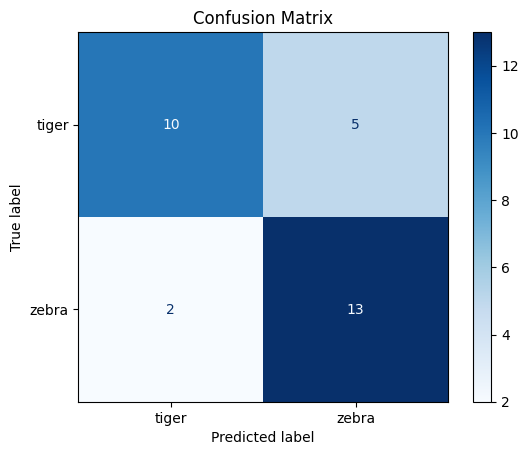

In [19]:
y_true = np.concatenate([y for _, y in test_ds], axis=0).flatten()
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# VGG

In [20]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10

In [21]:
# Загружаем VGG16 без головы
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Замораживаем веса (опционально, особенно на малом датасете)
base_model.trainiable = False

# Строим модель
inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
x = preprocess_input(inputs)  # ← критически важный шаг для VGG!
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Компиляция
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        513 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 14,715,201 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= EPOCHS,
    verbose=1
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 87s 10s/step - accuracy: 0.5273 - loss: 5.2935 - val_accuracy: 0.4667 - val_loss: 0.7601
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - accuracy: 0.6560 - loss: 0.6057 - val_accuracy: 0.8333 - val_loss: 0.3858
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - accuracy: 0.9090 - loss: 0.2570 - val_accuracy: 0.8333 - val_loss: 0.5398
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 550ms/step - accuracy: 0.8300 - loss: 0.5359 - val_accuracy: 0.8333 - val_loss: 0.5426
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - accuracy: 0.8647 - loss: 0.2649 - val_accuracy: 0.8667 - val_loss: 0.2301
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step - accuracy: 0.9252 - loss: 0.1870 - val_accuracy: 0.9333 - val_loss: 0.2060
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - accuracy: 0.9675 - loss: 0.1046 - val_accuracy: 0.9333 - val_loss: 0.1939
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - accuracy: 0.9601 - loss: 0.0841 - val_accuracy: 0.9333 - val_loss: 

In [23]:
y_true = []
y_pred_proba = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0).flatten()
    y_pred_proba.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = (np.array(y_pred_proba) > 0.5).astype(int)

## матрица ошибок

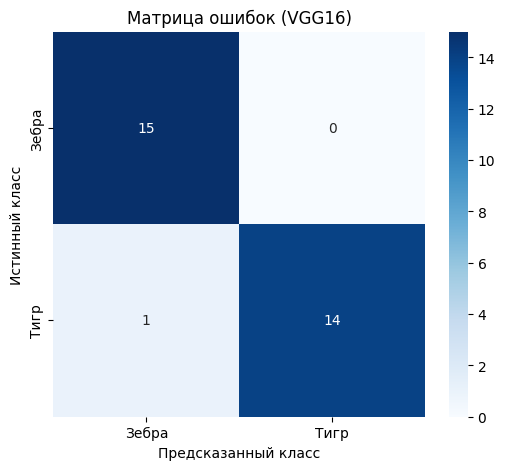

In [24]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Зебра', 'Тигр'],
            yticklabels=['Зебра', 'Тигр'])
plt.title("Матрица ошибок (VGG16)")
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.show()


In [26]:
print(classification_report(y_true, y_pred, target_names=['zebra', 'tiger']))

              precision    recall  f1-score   support

       zebra       0.94      1.00      0.97        15
       tiger       1.00      0.93      0.97        15

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



# YOLO

In [27]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [28]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.9 MB/s eta 0:00:00


In [29]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.7/112.6 GB disk)


In [30]:
from ultralytics import YOLO
model = YOLO("yolo12n.pt")
from IPython.display import display, Image

In [33]:
!yolo task=detect mode=predict model=yolo12n.pt conf=0.25 source='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/P.t.altaica_Tomak_Male.jpg/1280px-P.t.altaica_Tomak_Male.jpg' save=True

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,590,824 parameters, 0 gradients, 6.5 GFLOPs

WARNING ⚠️ Download failure, retrying 1/3 https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/P.t.altaica_Tomak_Male.jpg/1280px-P.t.altaica_Tomak_Male.jpg... HTTP Error 403: Forbidden
######################################################################## 100.0%
image 1/1 /content/1280px-P.t.altaica_Tomak_Male.jpg: 480x640 1 zebra, 80.6ms
Speed: 13.3ms preprocess, 80.6ms inference, 42.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


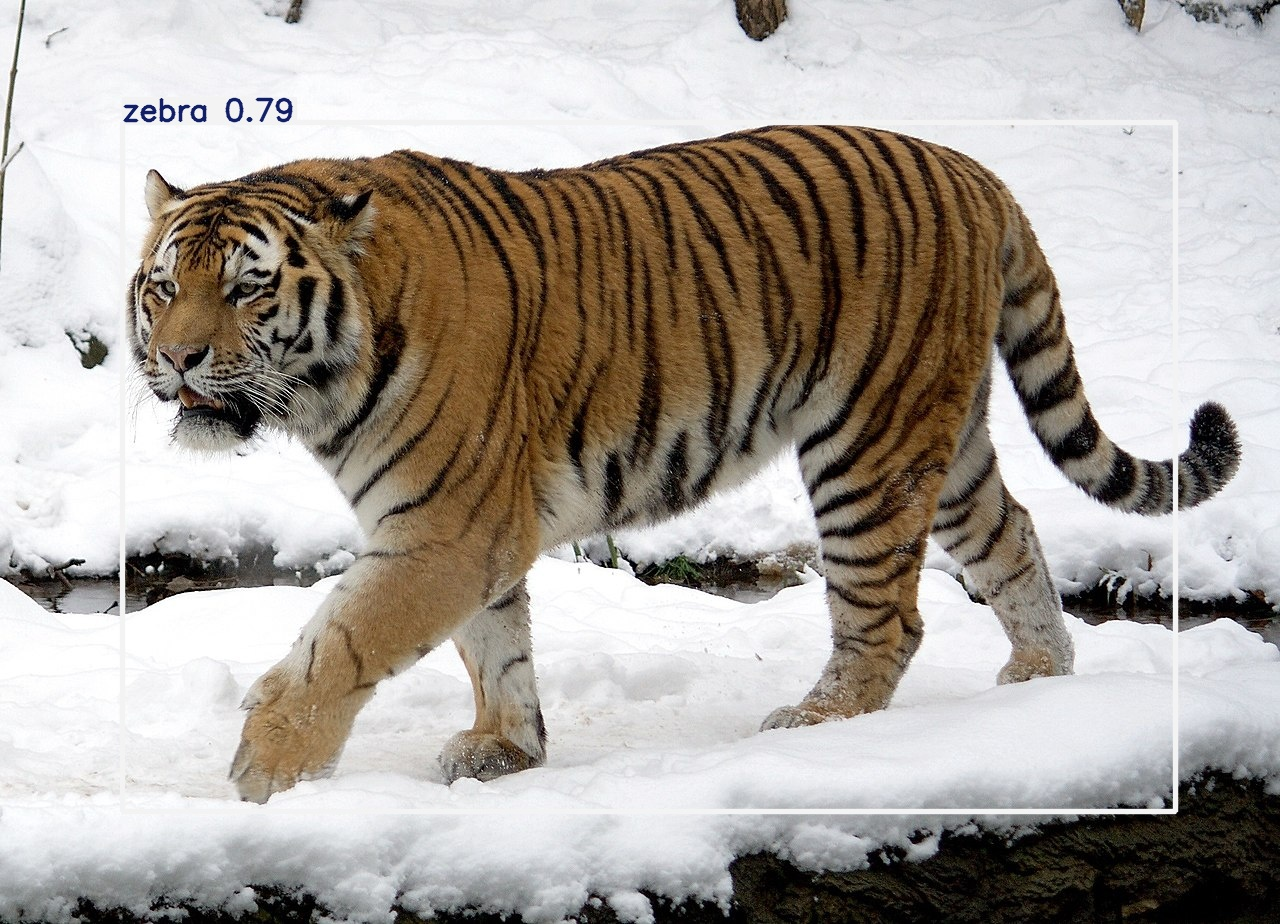

In [34]:
Image(filename='runs/detect/predict/1280px-P.t.altaica_Tomak_Male.jpg', height=600)

In [36]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="lkCAIDttWouhKEBiBKlT")
project = rf.workspace("ml-bhu80").project("my-first-project-xfv5b")
version = project.version(1)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-1 in yolov12:: 100%|██████████| 492/492 [00:00<00:00, 6940.50it/s]


In [42]:
print(f"{dataset.location}")


/content/My-First-Project-1


In [64]:
!yolo task=detect mode=train model=yolo12n.pt data=/content/My-First-Project-1/data.yaml epochs=50 imgsz=224 plots=True

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/My-First-Project-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tr

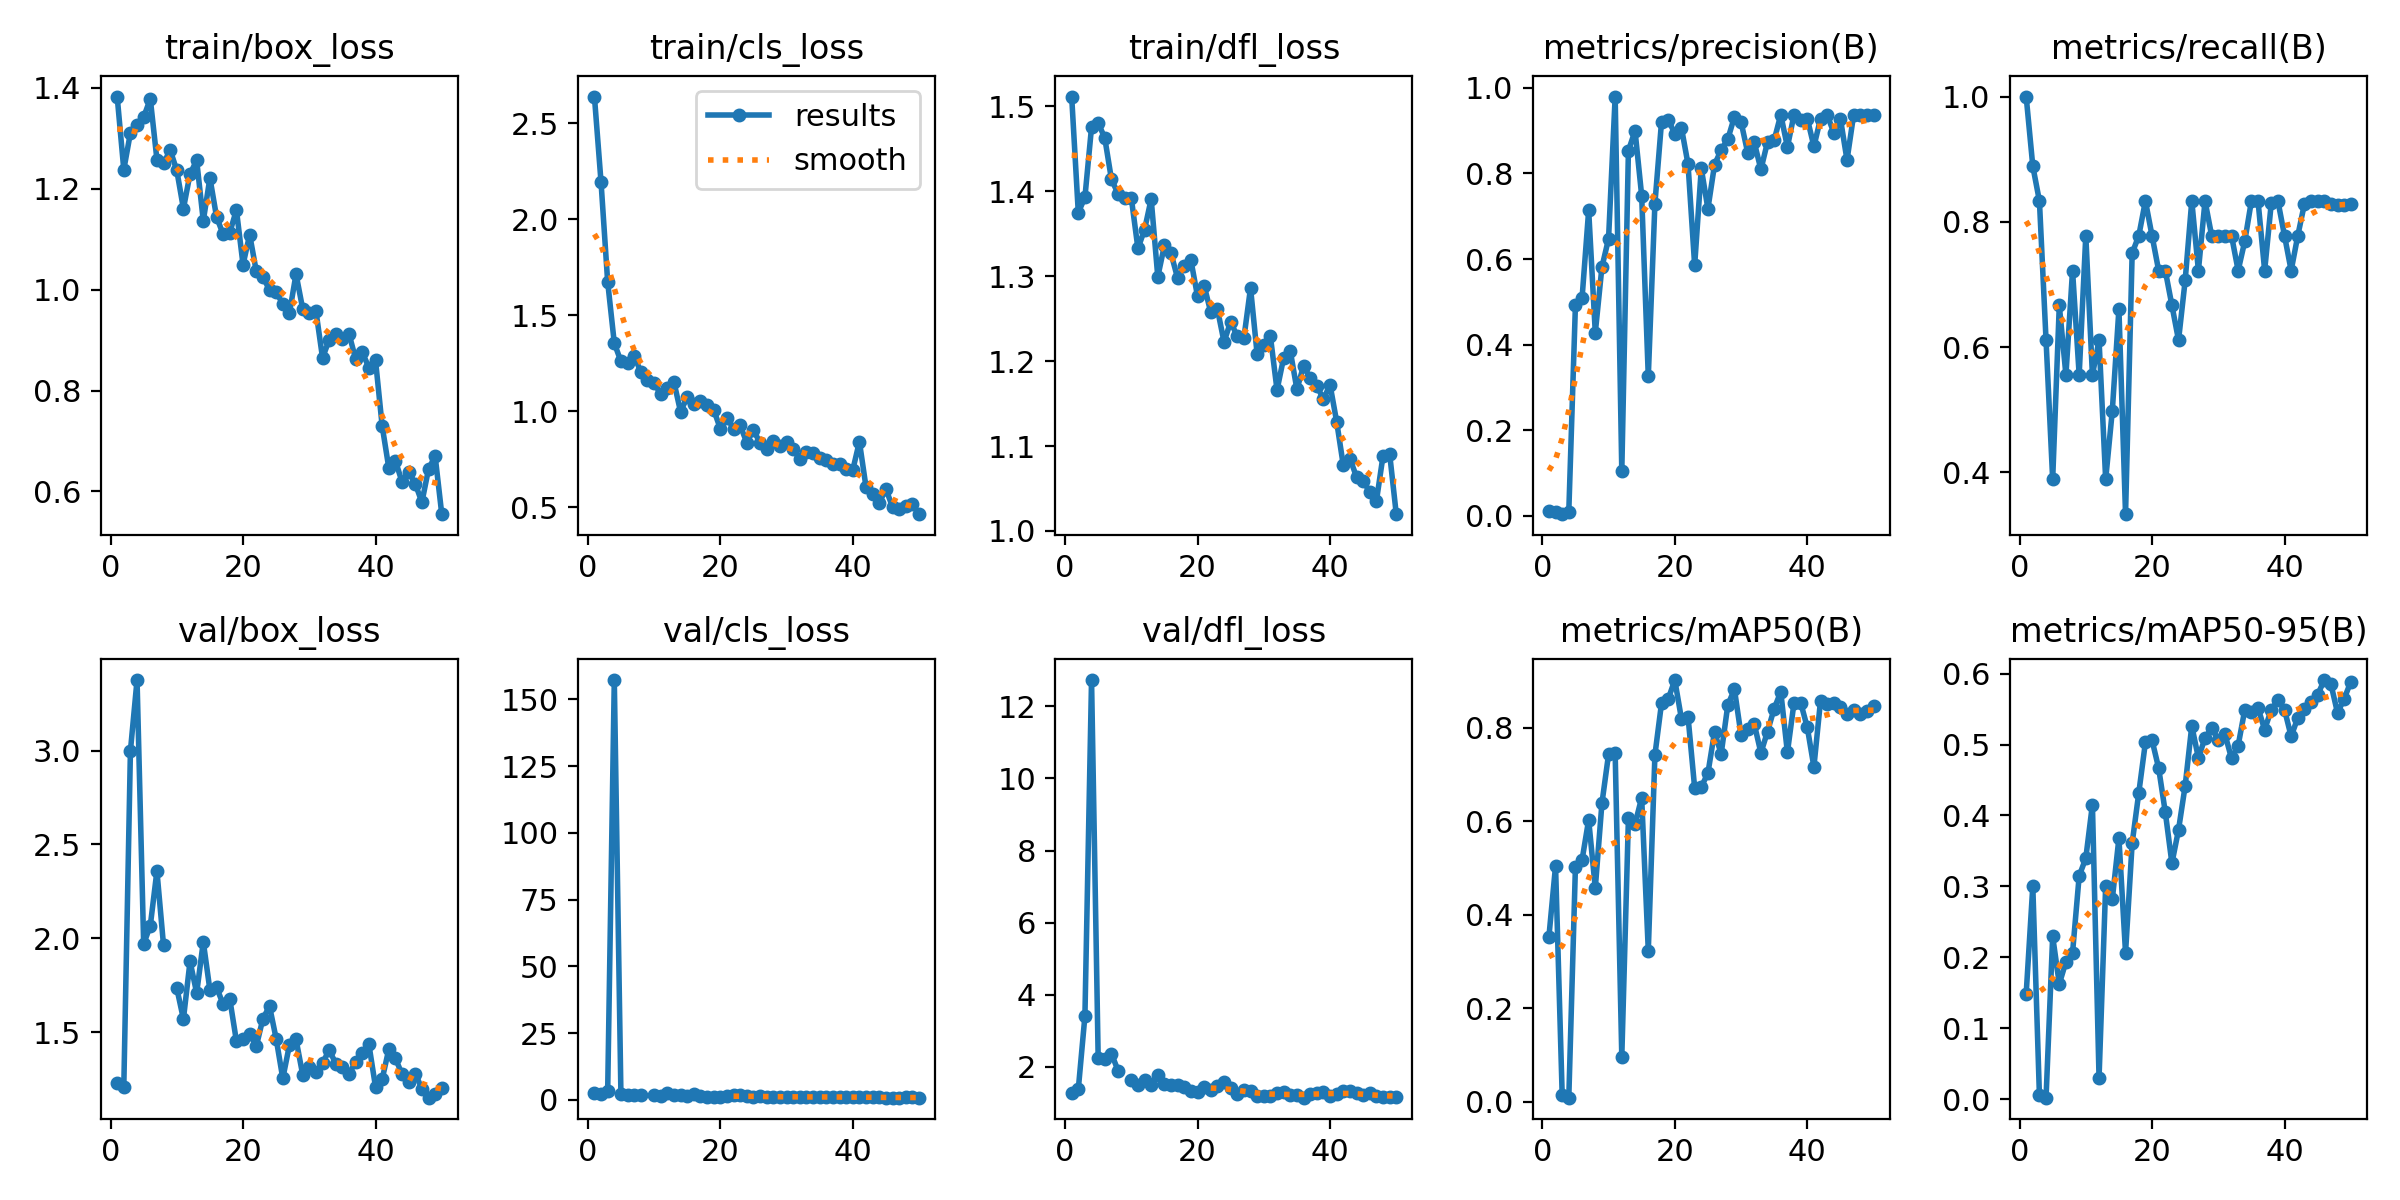

In [65]:
Image(filename=f'{HOME}/runs/detect/train6/results.png', width=600)

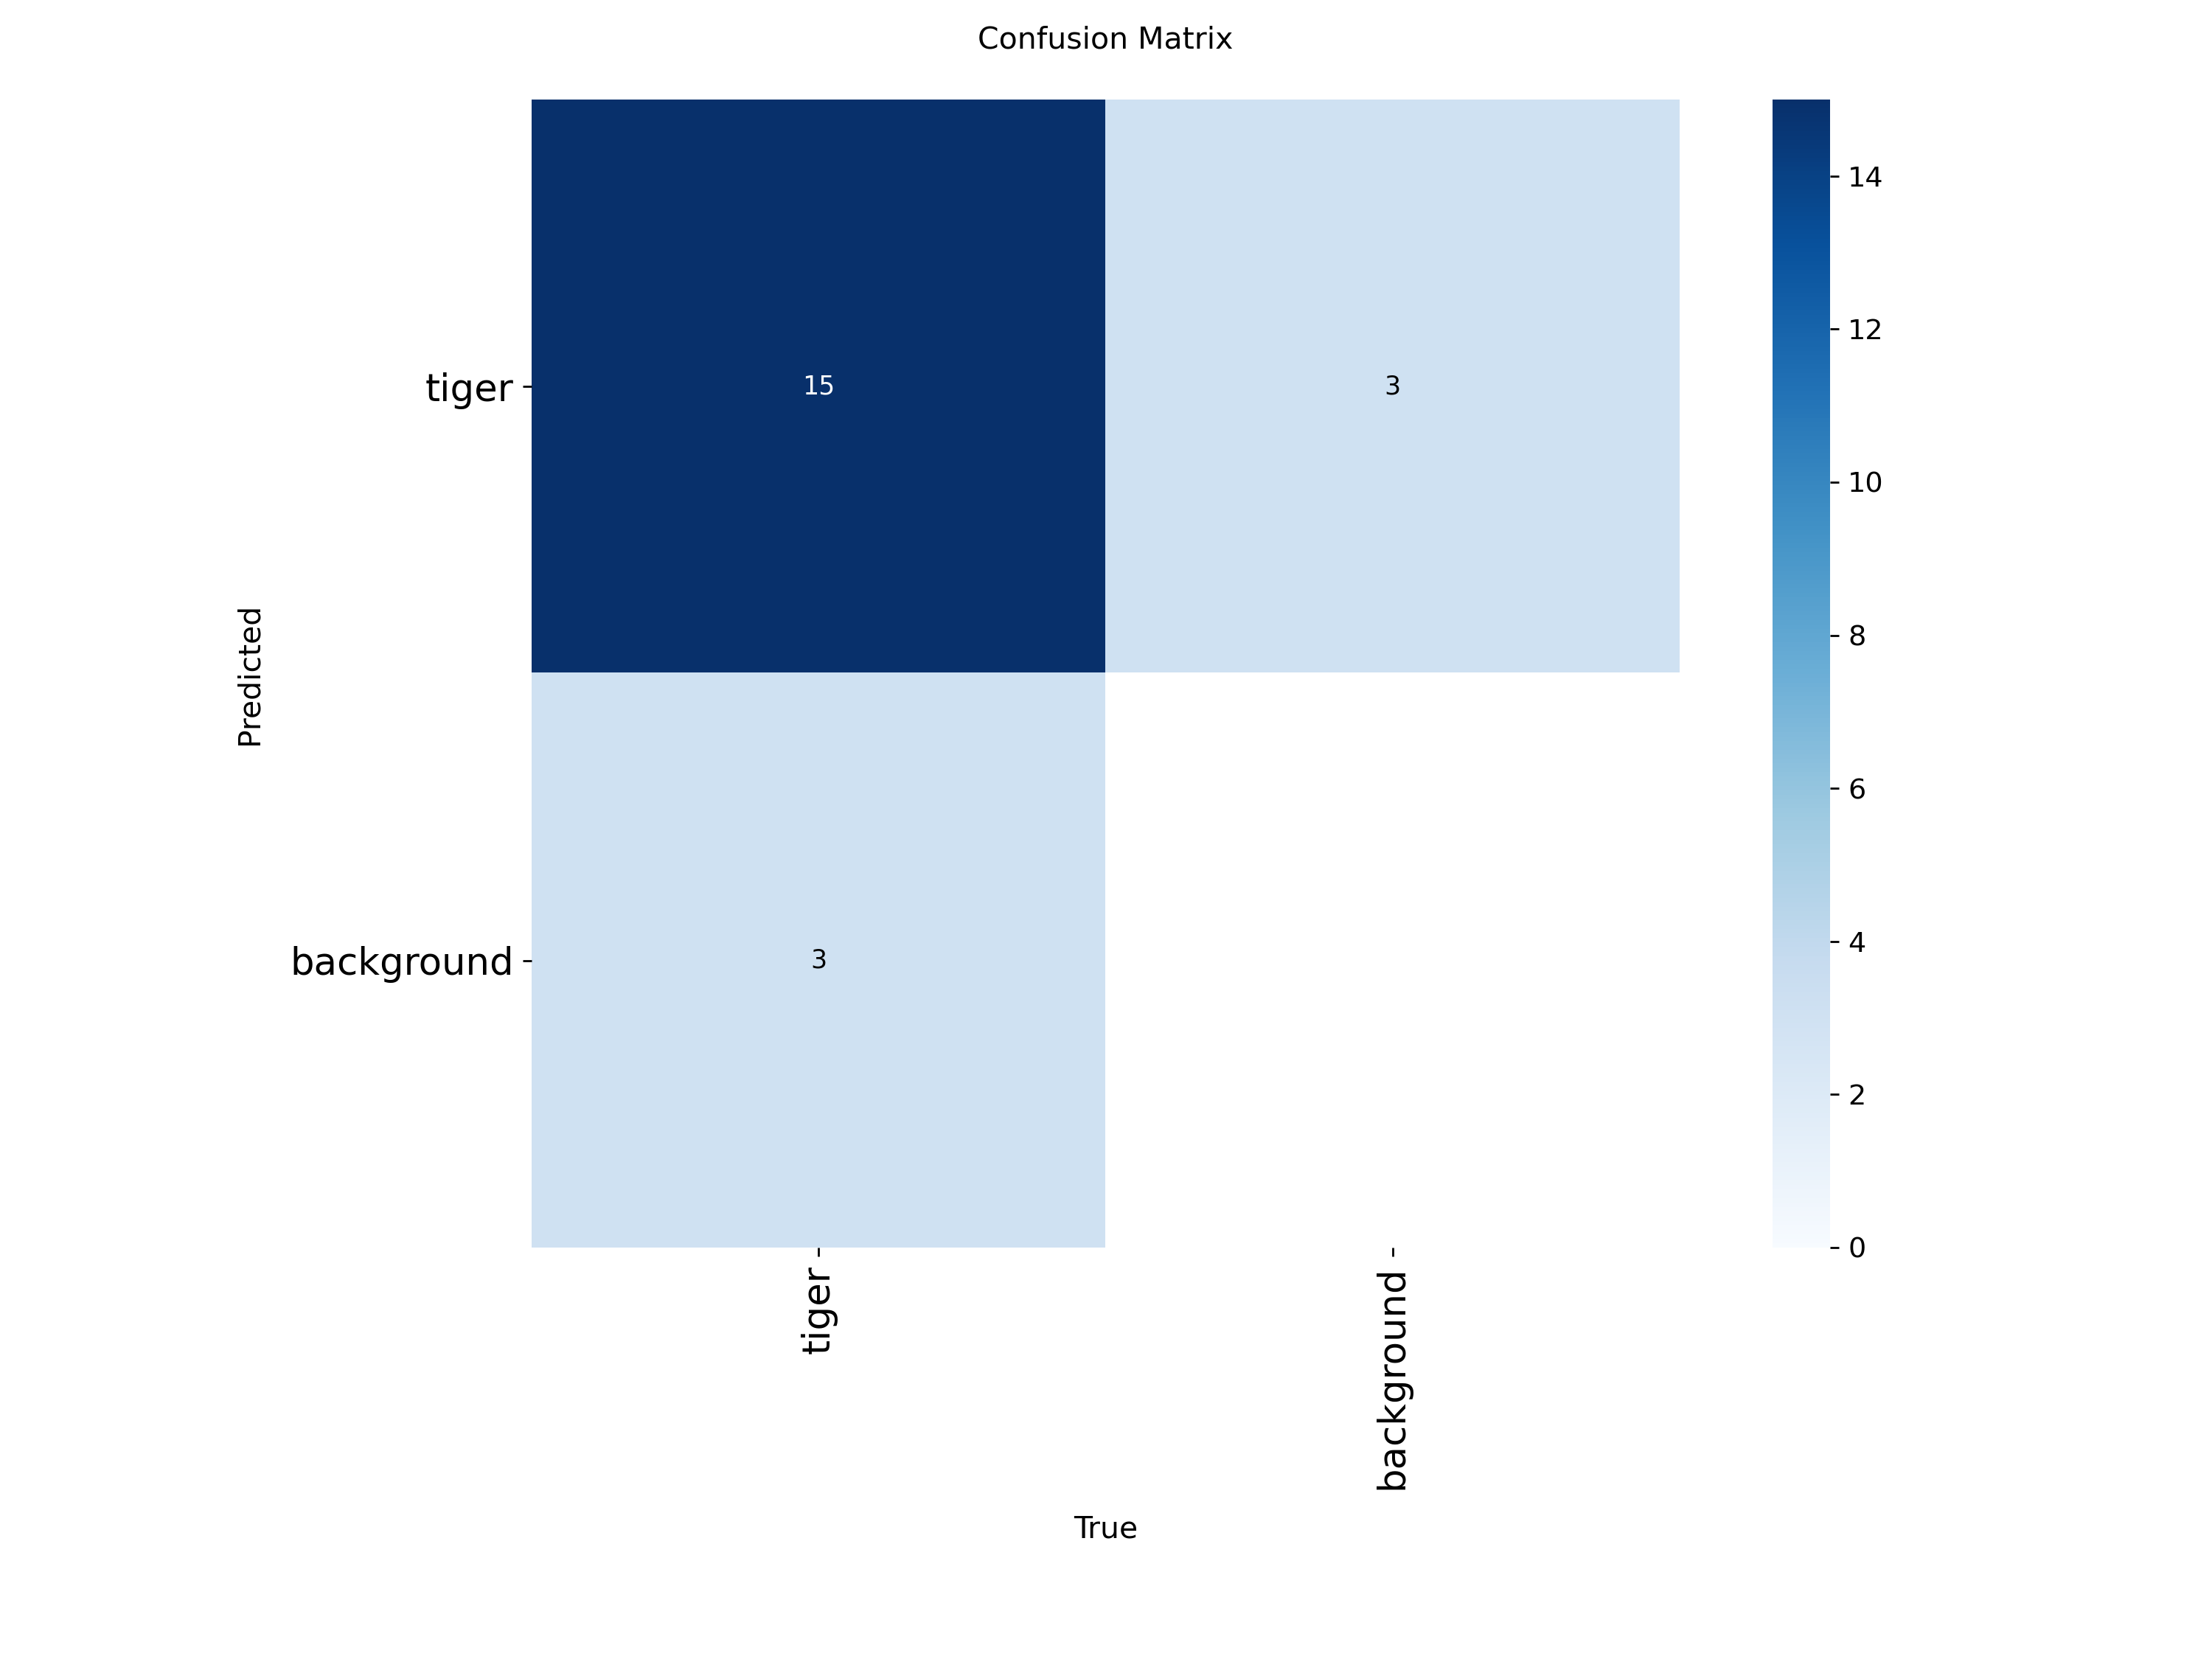

In [66]:
Image(filename=f'{HOME}/runs/detect/train6/confusion_matrix.png', width=600)

In [67]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train6/weights/best.pt conf=0.25 source=/content/My-First-Project-1/test/images save=True

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs

image 1/15 /content/My-First-Project-1/test/images/-_-_jpg.rf.adcf84c368e770e3566df629c61acaa7.jpg: 224x224 2 tigers, 21.0ms
image 2/15 /content/My-First-Project-1/test/images/-_jpg.rf.3decb85ff3b583d03fb162e3b2dc84e8.jpg: 224x224 1 tiger, 12.5ms
image 3/15 /content/My-First-Project-1/test/images/101-2-1-870x400_jpg.rf.84da5297759e6b7ccf57a69293a4ea21.jpg: 224x224 1 tiger, 13.9ms
image 4/15 /content/My-First-Project-1/test/images/11925-rss_jpg.rf.278e8ec9c733dde3245d7b072ec65593.jpg: 224x224 1 tiger, 11.9ms
image 5/15 /content/My-First-Project-1/test/images/15b4abdb66_jpg.rf.cf4473371464cd9b8789a513f43be1fb.jpg: 224x224 1 tiger, 13.4ms
image 6/15 /content/My-First-Project-1/test/images/2-21cdf848fc729163589c0ea6971abdbc_jpg.rf.fc9f3312eecf14441ff08fb607eda7f2.jpg: 224x224 1 tiger, 12.1ms
image 7/15 /content/My-First-Proj

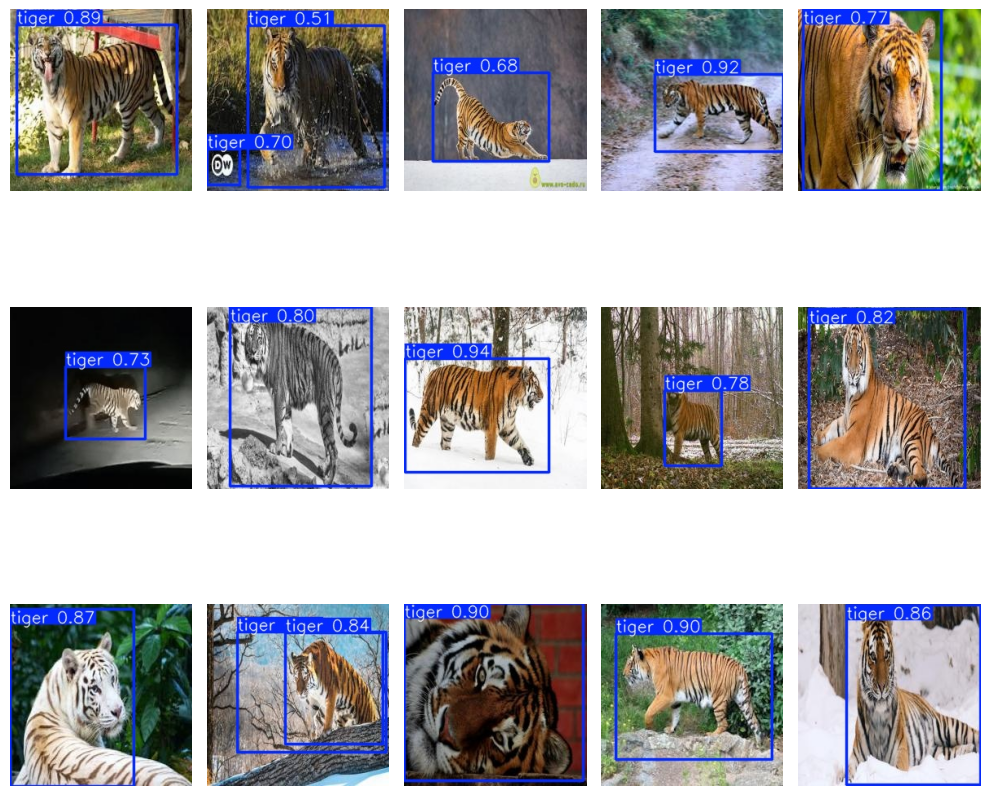

In [68]:
import matplotlib.pyplot as plt

# Создание сетки изображений
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

# Загрузка и отображение каждой картинки
image_files = os.listdir(f'{HOME}/runs/detect/predict8')

for i, ax in enumerate(axes.flat):
    image = plt.imread(f'{HOME}/runs/detect/predict8/{image_files[i]}')
    ax.imshow(image)
    ax.axis('off')

# Отображение сетки изображений
plt.tight_layout()
plt.show()

In [69]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train6/weights/best.pt conf=0.25 source='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/P.t.altaica_Tomak_Male.jpg/1280px-P.t.altaica_Tomak_Male.jpg' save=True

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs

Found https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/P.t.altaica_Tomak_Male.jpg/1280px-P.t.altaica_Tomak_Male.jpg locally at 1280px-P.t.altaica_Tomak_Male.jpg
image 1/1 /content/1280px-P.t.altaica_Tomak_Male.jpg: 192x224 1 tiger, 57.9ms
Speed: 0.8ms preprocess, 57.9ms inference, 16.6ms postprocess per image at shape (1, 3, 192, 224)
Results saved to /content/runs/detect/predict9
💡 Learn more at https://docs.ultralytics.com/modes/predict


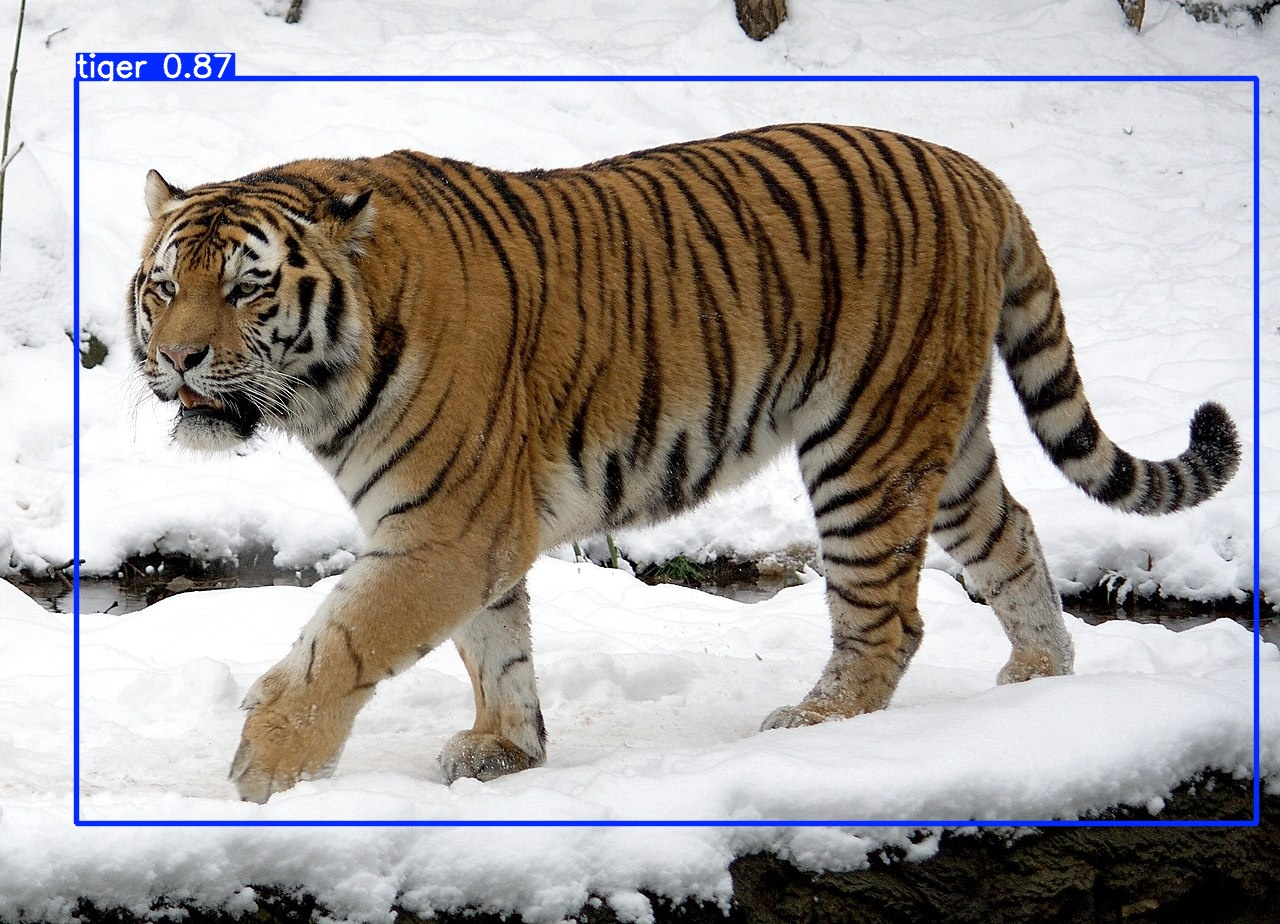

In [70]:
Image(filename='runs/detect/predict9/1280px-P.t.altaica_Tomak_Male.jpg', height=600)

In [71]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train6/weights/best.pt conf=0.25 source='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Plains_Zebra_Equus_quagga.jpg/500px-Plains_Zebra_Equus_quagga.jpg' save=True

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs

WARNING ⚠️ Download failure, retrying 1/3 https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Plains_Zebra_Equus_quagga.jpg/500px-Plains_Zebra_Equus_quagga.jpg... HTTP Error 403: Forbidden
######################################################################## 100.0%
image 1/1 /content/500px-Plains_Zebra_Equus_quagga.jpg: 224x160 2 tigers, 57.1ms
Speed: 1.0ms preprocess, 57.1ms inference, 17.5ms postprocess per image at shape (1, 3, 224, 160)
Results saved to /content/runs/detect/predict10
💡 Learn more at https://docs.ultralytics.com/modes/predict


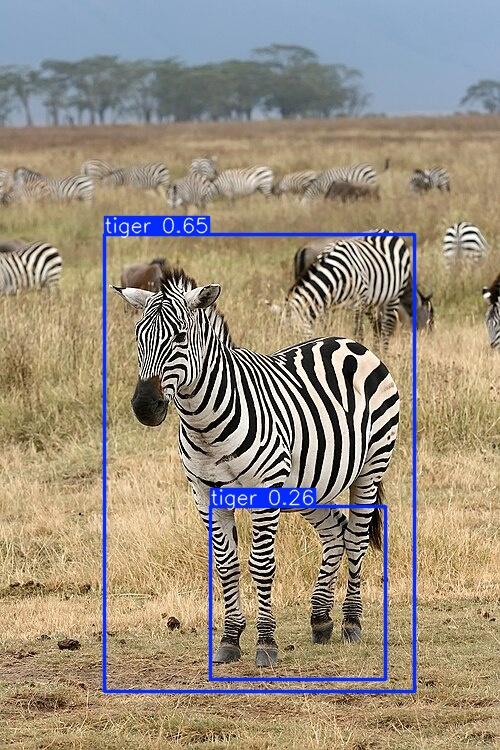

In [73]:
Image(filename='runs/detect/predict10/500px-Plains_Zebra_Equus_quagga.jpg', height=600)